In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import os
from torch import optim

In [0]:
!pwd

/content


In [0]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ll1 = nn.Linear(1211, 708)
        self.ll2 = nn.Linear(708, 708)
        self.ll3 = nn.Linear(708, 354)
        self.ll4 = nn.Linear(354, 354)
        self.oll = nn.Linear(354, 200) #changed from 16 to 200
    
    #function implements a forward pass to the network
    def forward(self, x):
        # x = x.flatten(start_dim=1) - flattening needed only for images
        x = F.relu(self.ll1(x))
        x = F.relu(self.ll2(x))
        x = F.relu(self.ll3(x))
        x = F.relu(self.ll4(x))
        x = F.softmax(self.oll(x))
        return x

In [0]:
Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward'))

In [0]:
class ReplayMemory():
    def __init__(self, capacity):
      self.capacity = capacity
      self.memory = []
      self.push_count = 0 #keep track of how many experiences we've added to memory
    
    #function to store experiences as they occur in replay memory
    def push(self, experience):
      if len(self.memory) < self.capacity:
          self.memory.append(experience)
      else:
          #if number of experiences exceeds capacity,
          #push the new experience to the front of memory, overriding the oldest experiences
          self.memory[self.push_count % self.capacity] = experience
      self.push_count += 1
    
    def sample(self, batch_size):
      return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size):
      return len(self.memory) >= batch_size

In [0]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
      self.start = start
      self.end = end
      self.decay = decay
    
    def get_exploration_rate(self, current_step):
      return self.end + (self.start - self.end) * \
          math.exp(-1. * current_step * self.decay)

In [0]:
class Agent():
    def __init__(self, strategy, num_actions, device):
      self.current_step = 0
      self.strategy = strategy
      self.num_actions = num_actions
      self.device = device
      self.mappings = defaultdict(tuple)

    def select_action(self, state, policy_net, possible_moves):
      #policy network is the deep Q network that we train to get the optimal policy
      rate = self.strategy.get_exploration_rate(self.current_step)
      # print("Exploration rate: ", rate)
      self.current_step += 1

      if rate > random.random():
        #print ('Exploring')
        action = random.choice(possible_moves) #pick a possible out of the available ones - change
        return torch.tensor(action[0]).to(self.device),rate # TODO - model action tensor    
        
      else:
        #turning off gradient tracking during inference, not training
        # print ('Exploiting')
        with torch.no_grad():
          #print(policy_net(state))
          returned_states = policy_net(state)
          max_value = float("-inf")
          max_index = 0
          # print("POSSIBLE MOVES: ", possible_moves)
          possible_moves_indexes = []
          for i in possible_moves:
            possible_moves_indexes.append(i[0])
          for index, value in enumerate(returned_states):
            if(index in possible_moves_indexes and value > max_value):
              max_value = value
              max_index = index
          max_index_tensor = torch.tensor(max_index)
          #result = policy_net(state).argmax(dim=-1).to(self.device)
          # print ('RESULT', max_index_tensor)
          return max_index_tensor, rate
          #return policy_net(torch.tensor(state)).argmax(dim=1).to(self.device) # exploit

    def select_action_testing(self, state, policy_net, possible_moves):    
      with torch.no_grad():
        #print(policy_net(state))
        returned_states = policy_net(state)
        max_value = float("-inf")
        max_index = 0
        # print("POSSIBLE MOVES: ", possible_moves)
        possible_moves_indexes = []
        
        for i in possible_moves:
          possible_moves_indexes.append(i[0])
        
        for index, value in enumerate(returned_states):
          if(index in possible_moves_indexes and value > max_value):
            max_value = value
            max_index = index
        max_index_tensor = torch.tensor(max_index)
        
        #print ('Result',max_index_tensor)
        return max_index_tensor
        #return policy_net(torch.tensor(state)).argmax(dim=1).to(self.device) # exploit

      '''
      During training PyTorch keeps track of all the forward pass calculations that happen within the network. 
      It needs to do this so that it can know how to apply backpropagation later. 
      Since we’re only using the model for inference at the moment, we’re telling PyTorch not to keep track of any forward pass calculations.
      - could this be a problem?
      '''

In [0]:
def one_hot_encode(value, size, max_value):
      a = np.array(value)
      b = np.zeros((size, max_value))
      b[np.arange(size), a-1] = 1
      return b.tolist()

def generate_feature_space(inital_st):
  #inital_st = [26, 5, [34, 29, 117, 174, 112], [[10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4]], 1]
  feature_space = []
  feature_space.extend(one_hot_encode(inital_st[0], 1, 199)[0])
  feature_space.append(inital_st[1])
  det_loc = one_hot_encode(inital_st[2], 5, 199)
  feature_space.extend(det_loc[0])
  feature_space.extend(det_loc[1])
  feature_space.extend(det_loc[2])
  feature_space.extend(det_loc[3])
  feature_space.extend(det_loc[4])
  det_tic = inital_st[3]
  feature_space.extend(det_tic[0])
  feature_space.extend(det_tic[1])
  feature_space.extend(det_tic[2])
  feature_space.extend(det_tic[3])
  feature_space.extend(det_tic[4])
  feature_space.append(inital_st[4])
  #print(feature_space)
  #print(len(feature_space))
  return feature_space

In [0]:
class Environment():
    def __init__(self, x_position, x_resources, detective_positions, detective_resources):
      TAXI = 'TAXI'
      BUS = 'BUS'
      UNDERGROUND = 'UNDERGROUND'
      BLACK = 'BLACK'
      self.board = (  ( (8, (TAXI,)), (9, (TAXI,)), (58, (BUS,)), (46, (BUS, UNDERGROUND)) ),  # locToRoutes[0] has no value; need to access locToRoutes[1] and higher               
         ( (8, (TAXI,)), (9, (TAXI,)), (58, (BUS,)), (46, (BUS, UNDERGROUND)) ),     # 001 
         ( (20, (TAXI,)), (10, (TAXI,)) ),
         ( (11, (TAXI,)), (12, (TAXI,)), (4, (TAXI,)), (22, (BUS,)), (23, (BUS,)) ),
         ( (3, (TAXI,)), (13, (TAXI,)) ),
         ( (15, (TAXI,)), (16, (TAXI,)) ),                                           # 005
         ( (29, (TAXI,)), (7, (TAXI,)) ),
         ( (6, (TAXI,)), (17, (TAXI,)), (42, (BUS,)) ),
         ( (1, (TAXI,)), (19, (TAXI,)), (18, (TAXI,)) ),
         ( (1, (TAXI,)), (19, (TAXI,)), (20, (TAXI,)) ),
         ( (2, (TAXI,)), (11, (TAXI,)), (34, (TAXI,)), (21, (TAXI,)) ),              # 010
         ( (3, (TAXI,)), (10, (TAXI,)), (22, (TAXI,)) ),
         ( (3, (TAXI,)), (23, (TAXI,)) ),
         ( (4, (TAXI,)), (14, (TAXI, BUS)), (24, (TAXI,)), (23, (TAXI, BUS)), (52, (BUS,)), 
            (89, (UNDERGROUND,)), (67, (UNDERGROUND,)), (46, (UNDERGROUND,)) ),
         ( (13, (TAXI, BUS)), (15, (TAXI, BUS)), (25, (TAXI,)) ),
         ( (5, (TAXI,)), (16, (TAXI,)), (28, (TAXI,)), (26, (TAXI,)), (14, (TAXI, BUS)),
            (29, (BUS,)), (41, (BUS,)) ),                                            # 015
         ( (5, (TAXI,)), (29, (TAXI,)), (28, (TAXI,)), (15, (TAXI,)) ),
         ( (7, (TAXI,)), (30, (TAXI,)), (29, (TAXI,)) ),
         ( (8, (TAXI,)), (31, (TAXI,)), (43, (TAXI,)) ),
         ( (8, (TAXI,)), (9, (TAXI,)), (32, (TAXI,)) ),
         ( (2, (TAXI,)), (9, (TAXI,)), (33, (TAXI,)) ),                              # 020
         ( (10, (TAXI,)), (33, (TAXI,)) ),
         ( (11, (TAXI,)), (23, (TAXI, BUS)), (35, (TAXI,)), (34, (TAXI, BUS)),
            (3, (BUS,)), (65, (BUS,)) ),
         ( (12, (TAXI,)), (13, (TAXI, BUS)), (37, (TAXI,)), (22, (TAXI, BUS)), 
            (3, (BUS,)), (67, (BUS,)) ),
         ( (13, (TAXI,)), (38, (TAXI,)), (37, (TAXI,)) ),
         ( (14, (TAXI,)), (39, (TAXI,)), (38, (TAXI,)) ),                            # 025
         ( (15, (TAXI,)), (27, (TAXI,)), (39, (TAXI,)) ),
         ( (26, (TAXI,)), (28, (TAXI,)), (40, (TAXI,)) ),
         ( (15, (TAXI,)), (16, (TAXI,)), (41, (TAXI,)), (27, (TAXI,)) ),
         ( (6, (TAXI,)), (17, (TAXI,)), (42, (TAXI, BUS)), (41, (TAXI, BUS)), (16, (TAXI,)),
            (55, (BUS,)), (15, (BUS,)) ),
         ( (17, (TAXI,)), (42, (TAXI,)) ),                                           # 030
         ( (18, (TAXI,)), (44, (TAXI,)), (43, (TAXI,)) ),
         ( (19, (TAXI,)), (33, (TAXI,)), (45, (TAXI,)), (44, (TAXI,)) ),
         ( (20, (TAXI,)), (21, (TAXI,)), (46, (TAXI,)), (32, (TAXI,)) ),
         ( (10, (TAXI,)), (22, (TAXI, BUS)), (48, (TAXI,)), (47, (TAXI,)), (63, (BUS,)),
            (46, (BUS,)) ),
         ( (22, (TAXI,)), (36, (TAXI,)), (65, (TAXI,)), (48, (TAXI,)) ),             # 035
         ( (37, (TAXI,)), (49, (TAXI,)), (35, (TAXI,)) ),
         ( (23, (TAXI,)), (24, (TAXI,)), (50, (TAXI,)), (36, (TAXI,)) ),
         ( (24, (TAXI,)), (25, (TAXI,)), (51, (TAXI,)), (50, (TAXI,)) ),
         ( (26, (TAXI,)), (52, (TAXI,)), (51, (TAXI,)), (25, (TAXI,)) ),
         ( (27, (TAXI,)), (41, (TAXI,)), (53, (TAXI,)), (52, (TAXI,)) ),             # 040
         ( (28, (TAXI,)), (29, (TAXI, BUS)), (54, (TAXI,)), (40, (TAXI,)),
            (15, (BUS,)), (87, (BUS,)), (52, (BUS,)) ),
         ( (30, (TAXI,)), (56, (TAXI,)), (72, (TAXI, BUS)), (29, (TAXI, BUS)),
            (7, (BUS,)) ),
         ( (18, (TAXI,)), (31, (TAXI,)), (57, (TAXI,)) ),
         ( (32, (TAXI,)), (58, (TAXI,)), (31, (TAXI,)) ),
         ( (32, (TAXI,)), (46, (TAXI,)), (60, (TAXI,)), (59, (TAXI,)),               # 045
            (58, (TAXI,)) ),
         ( (33, (TAXI,)), (47, (TAXI,)), (61, (TAXI,)), (45, (TAXI,)), (34, (BUS,)),
            (78, (BUS,)), (58, (BUS,)), (1, (BUS, UNDERGROUND)), (13, (UNDERGROUND,)),
            (79, (UNDERGROUND,)), (74, (UNDERGROUND,)) ),
         ( (34, (TAXI,)), (62, (TAXI,)), (46, (TAXI,)) ),
         ( (34, (TAXI,)), (35, (TAXI,)), (63, (TAXI,)), (62, (TAXI,)) ),
         ( (36, (TAXI,)), (50, (TAXI,)), (66, (TAXI,)) ),
         ( (37, (TAXI,)), (38, (TAXI,)), (49, (TAXI,)) ),                            # 050
         ( (38, (TAXI,)), (39, (TAXI,)), (52, (TAXI,)), (68, (TAXI,)), (67, (TAXI,)) ),
         ( (39, (TAXI,)), (40, (TAXI,)), (69, (TAXI,)), (51, (TAXI,)), (13, (BUS,)),
            (41, (BUS,)), (86, (BUS,)), (67, (BUS,)) ),
         ( (40, (TAXI,)), (54, (TAXI,)), (69, (TAXI,)) ),
         ( (41, (TAXI,)), (55, (TAXI,)), (70, (TAXI,)), (53, (TAXI,)) ),
         ( (71, (TAXI,)), (54, (TAXI,)), (29, (BUS,)), (89, (BUS,)) ),               # 055
         ( (42, (TAXI,)), (91, (TAXI,)) ),
         ( (43, (TAXI,)), (58, (TAXI,)), (73, (TAXI,)) ),
         ( (45, (TAXI,)), (59, (TAXI,)), (75, (TAXI,)), (74, (TAXI, BUS)), (57, (TAXI,)),
            (44, (TAXI,)), (46, (BUS,)), (77, (BUS,)), (1, (BUS,)) ),
         ( (45, (TAXI,)), (76, (TAXI,)), (75, (TAXI,)), (58, (TAXI,)) ),
         ( (45, (TAXI,)), (61, (TAXI,)), (76, (TAXI,)) ),                            # 060
         ( (46, (TAXI,)), (62, (TAXI,)), (78, (TAXI,)), (76, (TAXI,)), (60, (TAXI,)) ),
         ( (47, (TAXI,)), (48, (TAXI,)), (79, (TAXI,)), (61, (TAXI,)) ),
         ( (48, (TAXI,)), (64, (TAXI,)), (80, (TAXI,)), (79, (TAXI, BUS)),
            (34, (BUS,)), (65, (BUS,)), (100, (BUS,)) ),
         ( (65, (TAXI,)), (81, (TAXI,)), (63, (TAXI,)) ),
         ( (35, (TAXI,)), (66, (TAXI,)), (82, (TAXI, BUS)), (64, (TAXI,)),           # 065
            (22, (BUS,)), (67, (BUS,)), (63, (BUS,)) ),                                           
         ( (49, (TAXI,)), (67, (TAXI,)), (82, (TAXI,)), (65, (TAXI,)) ),
         ( (51, (TAXI,)), (68, (TAXI,)), (84, (TAXI,)), (66, (TAXI,)), (23, (BUS,)),
            (52, (BUS,)), (102, (BUS,)), (82, (BUS,)), (65, (BUS,)),
            (13, (UNDERGROUND,)), (89, (UNDERGROUND,)), (111, (UNDERGROUND,)),
            (79, (UNDERGROUND,)) ),
         ( (51, (TAXI,)), (69, (TAXI,)), (85, (TAXI,)), (67, (TAXI,)) ),
         ( (52, (TAXI,)), (53, (TAXI,)), (86, (TAXI,)), (68, (TAXI,)) ),
         ( (54, (TAXI,)), (71, (TAXI,)), (87, (TAXI,)) ),                            # 070
         ( (55, (TAXI,)), (72, (TAXI,)), (89, (TAXI,)), (70, (TAXI,)) ),
         ( (42, (TAXI, BUS)), (91, (TAXI,)), (90, (TAXI,)), (71, (TAXI,)),
            (107, (BUS,)), (105, (BUS,)) ),
         ( (57, (TAXI,)), (74, (TAXI,)), (92, (TAXI,)) ),
         ( (58, (TAXI, BUS)), (75, (TAXI,)), (92, (TAXI,)), (73, (TAXI,)),
            (94, (BUS,)), (46, (UNDERGROUND,)) ),
         ( (58, (TAXI,)), (59, (TAXI,)), (94, (TAXI,)), (74, (TAXI,)) ),             # 075
         ( (59, (TAXI,)), (60, (TAXI,)), (61, (TAXI,)), (77, (TAXI,)) ),
         ( (78, (TAXI, BUS)), (96, (TAXI,)), (95, (TAXI,)), (76, (TAXI,)),
            (124, (BUS,)), (94, (BUS,)), (58, (BUS,)) ),
         ( (61, (TAXI,)), (79, (TAXI, BUS)), (97, (TAXI,)), (77, (TAXI, BUS)),
            (46, (BUS,)) ),
         ( (62, (TAXI,)), (63, (TAXI, BUS)), (98, (TAXI,)), (78, (TAXI, BUS)),
            (46, (UNDERGROUND,)), (67, (UNDERGROUND,)), (111, (UNDERGROUND,)),
            (93, (UNDERGROUND,)) ),
         ( (63, (TAXI,)), (100, (TAXI,)), (99, (TAXI,)) ),                           # 080
         ( (64, (TAXI,)), (82, (TAXI,)), (100, (TAXI,)) ),
         ( (65, (TAXI, BUS)), (66, (TAXI,)), (67, (BUS,)), (101, (TAXI,)), (140, (BUS,)),
            (81, (TAXI,)), (100, (BUS,)) ),
         ( (102, (TAXI,)), (101, (TAXI,)) ),
         ( (67, (TAXI,)), (85, (TAXI,)) ),
         ( (68, (TAXI,)), (103, (TAXI,)), (84, (TAXI,)) ),                           # 085
         ( (69, (TAXI,)), (52, (BUS,)), (87, (BUS,)), (104, (TAXI,)), (116, (BUS,)),
            (103, (TAXI,)), (102, (BUS,)) ),
         ( (70, (TAXI,)), (41, (BUS,)), (88, (TAXI,)), (105, (BUS,)), (86, (BUS,)) ),
         ( (89, (TAXI,)), (117, (TAXI,)), (87, (TAXI,)) ),
         ( (71, (TAXI,)), (55, (BUS,)), (13, (UNDERGROUND,)), (105, (TAXI, BUS)),
            (128, (UNDERGROUND,)), (88, (TAXI,)), (140, (UNDERGROUND,)),
            (67, (UNDERGROUND,)) ),
         ( (72, (TAXI,)), (91, (TAXI,)), (105, (TAXI,)) ),                           # 090 
         ( (56, (TAXI,)), (107, (TAXI,)), (105, (TAXI,)), (90, (TAXI,)), (72, (TAXI,)) ),
         ( (73, (TAXI,)), (74, (TAXI,)), (93, (TAXI,)) ),
         ( (92, (TAXI,)), (94, (TAXI, BUS)), (79, (UNDERGROUND,)) ),
         ( (74, (BUS,)), (75, (TAXI,)), (95, (TAXI,)), (77, (BUS,)), (93, (TAXI, BUS)) ),
         ( (77, (TAXI,)), (122, (TAXI,)), (94, (TAXI,)) ),                           # 095
         ( (77, (TAXI,)), (97, (TAXI,)), (109, (TAXI,)) ),
         ( (78, (TAXI,)), (98, (TAXI,)), (109, (TAXI,)), (96, (TAXI,)) ),
         ( (79, (TAXI,)), (99, (TAXI,)), (110, (TAXI,)), (97, (TAXI,)) ),
         ( (80, (TAXI,)), (112, (TAXI,)), (110, (TAXI,)), (98, (TAXI,)) ),
         ( (81, (TAXI,)), (82, (BUS,)), (101, (TAXI,)), (113, (TAXI,)),              # 100
            (112, (TAXI,)), (111, (BUS,)), (80, (TAXI,)), (63, (BUS,)) ),
         ( (83, (TAXI,)), (114, (TAXI,)), (100, (TAXI,)), (82, (TAXI,)) ),
         ( (67, (BUS,)), (103, (TAXI,)), (86, (BUS,)), (115, (TAXI,)), (127, (BUS,)),
            (83, (TAXI,)) ),
         ( (85, (TAXI,)), (86, (TAXI,)), (102, (TAXI,)) ),
         ( (86, (TAXI,)), (116, (TAXI,)) ),
         ( (90, (TAXI,)), (72, (BUS,)), (91, (TAXI,)), (106, (TAXI,)),               # 105
            (107, (BUS,)), (108, (TAXI, BUS)), (87, (BUS,)), (89, (TAXI, BUS)) ),
         ( (107, (TAXI,)), (105, (TAXI,)) ),
         ( (91, (TAXI,)), (72, (BUS,)), (119, (TAXI,)), (161, (BUS,)),
            (106, (TAXI,)), (105, (BUS,)) ),
         ( (105, (TAXI, BUS)), (119, (TAXI,)), (135, (BUS,)), (117, (TAXI,)),
            (116, (BUS,)), (115, (BLACK,)) ),
         ( (97, (TAXI,)), (110, (TAXI,)), (124, (TAXI,)), (96, (TAXI,)) ),
         ( (99, (TAXI,)), (111, (TAXI,)), (109, (TAXI,)), (98, (TAXI,)) ),           # 110
         ( (112, (TAXI,)), (100, (BUS,)), (67, (UNDERGROUND,)),
            (153, (UNDERGROUND,)), (124, (TAXI, BUS)), (163, (UNDERGROUND,)),
            (110, (TAXI,)), (79, (UNDERGROUND,)) ),
         ( (100, (TAXI,)), (125, (TAXI,)), (111, (TAXI,)), (99, (TAXI,)) ),
         ( (114, (TAXI,)), (125, (TAXI,)), (100, (TAXI,)) ),
         ( (101, (TAXI,)), (115, (TAXI,)), (126, (TAXI,)),
            (132, (TAXI,)), (131, (TAXI,)), (113, (TAXI,)) ),
         ( (102, (TAXI,)), (127, (TAXI,)), (126, (TAXI,)), (114, (TAXI,)),           # 115
            (108, (BLACK,)), (157, (BLACK,)) ),
         ( (104, (TAXI,)), (86, (BUS,)), (117, (TAXI,)), (108, (BUS,)),
            (118, (TAXI,)), (142, (BUS,)), (127, (TAXI, BUS)) ),
         ( (88, (TAXI,)), (108, (TAXI,)), (129, (TAXI,)), (116, (TAXI,)) ),
         ( (116, (TAXI,)), (129, (TAXI,)), (142, (TAXI,)), (134, (TAXI,)) ),
         ( (107, (TAXI,)), (136, (TAXI,)), (108, (TAXI,)) ),
         ( (121, (TAXI,)), (144, (TAXI,)) ),                                         # 120
         ( (122, (TAXI,)), (145, (TAXI,)), (120, (TAXI,)) ),
         ( (95, (TAXI,)), (123, (TAXI, BUS)), (146, (TAXI,)),
            (121, (TAXI,)), (144, (BUS,)) ),
         ( (124, (TAXI, BUS)), (149, (TAXI,)), (165, (BUS,)), (148, (TAXI,)),
            (137, (TAXI,)), (144, (BUS,)), (122, (TAXI, BUS)) ),
         ( (109, (TAXI,)), (111, (TAXI, BUS)), (130, (TAXI,)), (138, (TAXI,)),
            (153, (BUS,)), (123, (TAXI, BUS)), (77, (BUS,)) ),
         ( (113, (TAXI,)), (131, (TAXI,)), (112, (TAXI,)) ),                         # 125
         ( (115, (TAXI,)), (127, (TAXI,)), (140, (TAXI,)), (114, (TAXI,)) ),
         ( (116, (TAXI, BUS)), (134, (TAXI,)), (133, (TAXI, BUS)),
            (126, (TAXI,)), (115, (TAXI,)), (102, (BUS,)) ),
         ( (143, (TAXI,)), (135, (BUS,)), (89, (UNDERGROUND,)), (160, (TAXI,)),
            (161, (BUS,)), (188, (TAXI,)), (199, (BUS,)), (172, (TAXI,)),
            (187, (BUS,)), (185, (UNDERGROUND,)), (142, (TAXI, BUS)),
            (140, (UNDERGROUND,)) ),
         ( (117, (TAXI,)), (135, (TAXI,)), (143, (TAXI,)), (142, (TAXI,)),
            (118, (TAXI,)) ),
         ( (131, (TAXI,)), (139, (TAXI,)), (124, (TAXI,)) ),                         # 130
         ( (114, (TAXI,)), (130, (TAXI,)), (125, (TAXI,)) ),
         ( (114, (TAXI,)), (140, (TAXI,)) ),
         ( (127, (TAXI, BUS)), (141, (TAXI,)), (157, (BUS,)), (140, (TAXI, BUS)) ),
         ( (118, (TAXI,)), (142, (TAXI,)), (141, (TAXI,)), (127, (TAXI,)) ),
         ( (108, (BUS,)), (136, (TAXI,)), (161, (TAXI, BUS)), (143, (TAXI,)),        # 135
            (128, (BUS,)), (129, (TAXI,)) ),
         ( (119, (TAXI,)), (162, (TAXI,)), (135, (TAXI,)) ),
         ( (123, (TAXI,)), (147, (TAXI,)) ),
         ( (152, (TAXI,)), (150, (TAXI,)), (124, (TAXI,)) ),
         ( (130, (TAXI,)), (140, (TAXI,)), (154, (TAXI,)), (153, (TAXI,)) ),
         ( (132, (TAXI,)), (82, (BUS,)), (126, (TAXI,)), (89, (UNDERGROUND,)),       # 140
            (133, (TAXI, BUS)), (128, (UNDERGROUND,)), (156, (TAXI, BUS)),
            (154, (TAXI, BUS)), (153, (UNDERGROUND,)), (139, (TAXI,)) ),
         ( (134, (TAXI,)), (142, (TAXI,)), (158, (TAXI,)), (133, (TAXI,)) ),
         ( (118, (TAXI,)), (116, (BUS,)), (129, (TAXI,)), (143, (TAXI,)),
            (128, (TAXI, BUS)), (158, (TAXI,)), (157, (BUS,)), (141, (TAXI,)),
            (134, (TAXI,)) ),
         ( (135, (TAXI,)), (160, (TAXI,)), (128, (TAXI,)), (142, (TAXI,)),
            (129, (TAXI,)) ),
         ( (120, (TAXI,)), (122, (BUS,)), (145, (TAXI,)), (123, (BUS,)),
            (163, (BUS,)), (177, (TAXI,)) ),
         ( (121, (TAXI,)), (146, (TAXI,)), (144, (TAXI,)) ),                         # 145
         ( (122, (TAXI,)), (147, (TAXI,)), (163, (TAXI,)), (145, (TAXI,)) ),
         ( (137, (TAXI,)), (164, (TAXI,)), (146, (TAXI,)) ),
         ( (123, (TAXI,)), (149, (TAXI,)), (164, (TAXI,)) ),
         ( (123, (TAXI,)), (150, (TAXI,)), (165, (TAXI,)), (148, (TAXI,)) ),
         ( (138, (TAXI,)), (151, (TAXI,)), (149, (TAXI,)) ),                         # 150
         ( (152, (TAXI,)), (166, (TAXI,)), (165, (TAXI,)), (150, (TAXI,)) ),
         ( (153, (TAXI,)), (151, (TAXI,)), (138, (TAXI,)) ),
         ( (139, (TAXI,)), (111, (UNDERGROUND,)), (154, (TAXI, BUS)),
            (140, (UNDERGROUND,)), (167, (TAXI,)), (184, (BUS,)),
            (185, (UNDERGROUND,)), (166, (TAXI,)), (180, (BUS,)),
            (163, (UNDERGROUND,)), (152, (TAXI,)), (124, (BUS,)) ),
         ( (140, (TAXI, BUS)), (155, (TAXI,)), (156, (BUS,)), (153, (TAXI, BUS)),
            (139, (TAXI,)) ),
         ( (156, (TAXI,)), (168, (TAXI,)), (167, (TAXI,)), (154, (TAXI,)) ),         # 155
         ( (140, (TAXI, BUS)), (157, (TAXI, BUS)), (169, (TAXI,)),
            (184, (BUS,)), (155, (TAXI,)), (154, (BUS,)) ),
         ( (133, (BUS,)), (158, (TAXI,)), (142, (BUS,)), (170, (TAXI,)),
            (185, (BUS,)), (156, (TAXI, BUS)), (115, (BLACK,)), (194, (BLACK,)) ),
         ( (141, (TAXI,)), (142, (TAXI,)), (159, (TAXI,)), (157, (TAXI,)) ),
         ( (158, (TAXI,)), (172, (TAXI,)), (198, (TAXI,)), (186, (TAXI,)),
            (170, (TAXI,)) ),
         ( (143, (TAXI,)), (161, (TAXI,)), (173, (TAXI,)), (128, (TAXI,)) ),         # 160
         ( (107, (BUS,)), (174, (TAXI,)), (199, (BUS,)), (160, (TAXI,)),
            (128, (BUS,)), (135, (TAXI, BUS)) ),
         ( (175, (TAXI,)), (136, (TAXI,)) ),
         ( (146, (TAXI,)), (111, (UNDERGROUND,)), (153, (UNDERGROUND,)),
            (191, (BUS,)), (177, (TAXI,)), (176, (BUS,)), (144, (BUS,)) ),
         ( (147, (TAXI,)), (148, (TAXI,)), (179, (TAXI,)), (178, (TAXI,)) ),
         ( (149, (TAXI,)), (123, (BUS,)), (151, (TAXI,)), (180, (TAXI, BUS)),        # 165
            (179, (TAXI,)), (191, (BUS,)) ),
         ( (153, (TAXI,)), (183, (TAXI,)), (181, (TAXI,)), (151, (TAXI,)) ),
         ( (155, (TAXI,)), (168, (TAXI,)), (183, (TAXI,)), (153, (TAXI,)) ),
         ( (155, (TAXI,)), (184, (TAXI,)), (167, (TAXI,)) ),
         ( (156, (TAXI,)), (184, (TAXI,)) ),
         ( (157, (TAXI,)), (159, (TAXI,)), (185, (TAXI,)) ),                         # 170
         ( (173, (TAXI,)), (175, (TAXI,)), (199, (TAXI,)) ),
         ( (128, (TAXI,)), (187, (TAXI,)), (159, (TAXI,)) ),
         ( (160, (TAXI,)), (174, (TAXI,)), (171, (TAXI,)), (188, (TAXI,)) ),
         ( (175, (TAXI,)), (173, (TAXI,)), (161, (TAXI,)) ),
         ( (162, (TAXI,)), (171, (TAXI,)), (174, (TAXI,)) ),                         # 175
         ( (177, (TAXI,)), (163, (BUS,)), (189, (TAXI,)), (190, (BUS,)) ),
         ( (144, (TAXI,)), (163, (TAXI,)), (176, (TAXI,)) ),
         ( (164, (TAXI,)), (191, (TAXI,)), (189, (TAXI,)) ),
         ( (165, (TAXI,)), (191, (TAXI,)), (164, (TAXI,)) ),
         ( (165, (TAXI, BUS)), (181, (TAXI,)), (153, (BUS,)), (193, (TAXI,)),        # 180
            (184, (BUS,)), (190, (BUS,)) ),
         ( (166, (TAXI,)), (182, (TAXI,)), (193, (TAXI,)), (180, (TAXI,)) ),
         ( (183, (TAXI,)), (195, (TAXI,)), (181, (TAXI,)) ), 
         ( (167, (TAXI,)), (196, (TAXI,)), (182, (TAXI,)), (166, (TAXI,)) ),
         ( (169, (TAXI,)), (156, (BUS,)), (185, (TAXI, BUS)), (197, (TAXI,)),
            (196, (TAXI,)), (180, (BUS,)), (168, (TAXI,)), (153, (BUS,)) ),
         ( (170, (TAXI,)), (157, (BUS,)), (186, (TAXI,)), (187, (BUS,)),             # 185
            (128, (UNDERGROUND,)), (184, (TAXI, BUS)), (153, (UNDERGROUND,)) ),
         ( (159, (TAXI,)), (198, (TAXI,)), (185, (TAXI,)) ),
         ( (172, (TAXI,)), (128, (BUS,)), (188, (TAXI,)), (198, (TAXI,)),
            (185, (BUS,)) ),
         ( (128, (TAXI,)), (173, (TAXI,)), (199, (TAXI,)), (187, (TAXI,)) ),
         ( (178, (TAXI,)), (190, (TAXI,)), (176, (TAXI,)) ),
         ( (191, (TAXI, BUS)), (192, (TAXI,)), (180, (BUS,)),                        # 190
            (189, (TAXI,)), (176, (BUS,)) ),
         ( (179, (TAXI,)), (165, (BUS,)), (192, (TAXI,)), (190, (TAXI, BUS)),
            (178, (TAXI,)), (163, (BUS,)) ),
         ( (191, (TAXI,)), (194, (TAXI,)), (190, (TAXI,)) ),
         ( (181, (TAXI,)), (194, (TAXI,)), (180, (TAXI,)) ),
         ( (195, (TAXI,)), (192, (TAXI,)), (193, (TAXI,)), (157, (BLACK,)) ),
         ( (182, (TAXI,)), (197, (TAXI,)), (194, (TAXI,)) ),                         # 195
         ( (183, (TAXI,)), (184, (TAXI,)), (197, (TAXI,)) ),
         ( (196, (TAXI,)), (184, (TAXI,)), (195, (TAXI,)) ),
         ( (159, (TAXI,)), (187, (TAXI,)), (199, (TAXI,)), (186, (TAXI,)) ),
         ( (188, (TAXI,)), (128, (BUS,)), (171, (TAXI,)), (161, (BUS,)),
            (198, (TAXI,)) ) 
      )
      
      self.x_position = x_position
      self.detective_positions = detective_positions
      self.x_resources =  x_resources
      #self.detective_resources = detective_resources
      self.detective_resources = [[10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4]]
      self.done = False
      self.possible_moves = self.board[self.x_position]
   
    def take_action_detectives_random(self):
      d = {
          "TAXI":0,
           "BUS":1,
           "UNDERGROUND":2,
           "BLACK":3
      }
      # print(self.detective_resources)
      for index, each_detective in enumerate(self.detective_positions):
        pm = self.board[each_detective]
        new_pm = []
        for x in pm:
          for k in range(0, len(x[1])):
            if(x[1][k] != "BLACK"):

              if(self.detective_resources[index][d[x[1][k]]] > 0):
                new_pm.append((x[0], x[1][k]))
        if(len(new_pm) > 0):
          random_move = random.choice(new_pm)
        
          # print(random_move)
          if 'TAXI' == random_move[1]:
            resource_used = 0
            
          elif 'BUS' == random_move[1]:
            resource_used = 1
          
          else:
            resource_used = 2

          
          self.detective_positions[index] = random_move[0]
          self.detective_resources[index][resource_used]-=1
      

    def take_action_detectives(self):
      res_state_loc = []
      res_state_resources = self.detective_resources

      for count, det in enumerate(self.detective_positions):
        moves = self.board[int(det)]
        min_dist_node = -1
        min_dist_val = float("inf")
        
        for move in moves:
          val = self.getdistance(self.x_position, move[0])
          
          if(val<min_dist_val):
            #TODO: MAKE SURE DETECTIVE DONT MOVE IF THERE ARE NO RESOURCES
            min_dist_node = move
            min_dist_val = val

        res_state_loc.append(min_dist_node[0])
        # print("COUNT: ", count)
        if(min_dist_node[1][0] == 'TAXI'):
          res_state_resources[count][0] = max(res_state_resources[count][0] -1,0)

        elif(min_dist_node[1][0] == 'BUS'):
          res_state_resources[count][1] = max(res_state_resources[count][1] -1,0)        
        else:
          res_state_resources[count][2] = max(res_state_resources[count][2] -1,0)      
      return (res_state_loc, res_state_resources)
      
    def get_state(self, round_number):
      in_state = [self.x_position, self.x_resources, self.detective_positions, self.detective_resources, round_number]
      state = generate_feature_space(in_state)
      return torch.tensor(state)
    
    def getdistance(self, x, y):
      #TODO
      return abs(int(x) - int(y))

    def num_actions_available(self):
      return len(self.possible_moves)

    def take_action(self, action, timestep):
      #update Mr. X's position to simulate his taking an action
      self.x_position = action

      '''det_actions = take_action_detectives()
      self.detective_positions = det_actions[0]
      self.detective_resources = det_actions[1]'''

      self.take_action_detectives_random()
      
      # detective_position_average = 0
      # for each_detective in self.detective_positions:
      #   detective_position_average += each_detective
      # detective_position_average = detective_position_average/5

      # reward = self.getdistance(self.x_position, detective_position_average)
      self.done = self.is_done(timestep)
      if self.done == 1:
        return -100
      elif(self.done == 2):
        return 100
      else:
        return 0
    
     
    def is_done(self, timestep):
      #game ends when either one detective is at the place of Mr. X
      for each_detective in self.detective_positions:
        if each_detective == self.x_position:
          return 1
      if(timestep == 24):
        return 2
      return 0
    #returns true is mr_x wins 
    def winner(self):

      for each_detective in self.detective_positions:
        if each_detective == self.x_position:
          return False
      return True
 
      

In [0]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values


In [0]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))
    #print ('BATCH',batch)
    t1 = torch.stack(batch.state)
    t4 = torch.stack(batch.next_state)
    t3 = torch.stack(batch.reward)
    t2 = torch.stack(batch.action)
    #t3 = torch.cat(batch.reward)
    #t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [0]:
def plot_training(rates,performance):
  # plotting the points  
  plt.plot(rates, performance, color='green', linestyle='solid', linewidth = 3)
  
  # naming the x axis 
  plt.xlabel('Explore') 
  # naming the y axis 
  plt.ylabel('Mr. X Wins - Detective Wins') 

  # giving a title to the graph 
  plt.title('Training') 

  # invert the x-axis on the graph
  #plt.gca().invert_xaxis()
  
  # function to show the plot 
  plt.show() 

def plot_testing(performance,games):
  # plotting the points  
  plt.plot(games, performance, color='green', linestyle='solid', linewidth = 3)
  
  # naming the x axis 
  plt.xlabel('Game Number') 

  # naming the y axis 
  plt.ylabel('Mr. X Wins - Detective Win') 

  # giving a title to my graph 
  plt.title('Testing') 

  # function to show the plot 
  plt.show() 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode number:  0
Episode number:  1
Episode number:  2
Episode number:  3
Episode number:  4
Episode number:  5
Episode number:  6
Episode number:  7
Episode number:  8
Episode number:  9
Episode number:  10
Episode number:  11
Episode number:  12
Episode number:  13
Episode number:  14
Episode number:  15
Episode number:  16
Episode number:  17
Episode number:  18
Episode number:  19
Episode number:  20
Episode number:  21
Episode number:  22
Episode number:  23
Episode number:  24
Episode number:  25
Episode number:  26
Episode number:  27
Episode number:  28
Episode number:  29
Episode number:  30
Episode number:  31
Episode number:  32
Episode number:  33
Episode number:  34
Episode number:  35
Episode number:  36
Episode number:  37
Episode number:  38
Episode number:  39
Episode number:  40
Episode number:  41
Episode number:  42
Episode number:  43
Episode number:  44
Episode number:  45
Episode number:  46
Episode number:  47
Episode number:  48
Episode number:  49
Episode nu

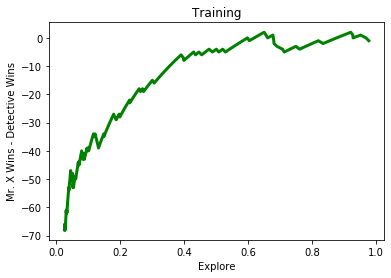

In [0]:
'''
Should X position be tensor or not, and how to pass action tuple + need to handle multiple modes of transport in action.
'''

batch_size = 55 #256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # how often we update target with policy n/w
memory_size = 100000 #check with paper
lr = 0.001
num_episodes = 200 #1000
# state_dim = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#start_state = [26, 5, [34, 29, 117, 174, 112], [[10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4]], 1]
start_state = [165, 5, [34, 29, 117, 174, 112], [[10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4]], 1]
start_feature = generate_feature_space(start_state)
#print ('Length',len(start_feature))
#print ('Without tensor',start_feature)
#print ('With tensor',torch.tensor(start_feature).size())

em = Environment(start_state[0], start_state[1], start_state[2], start_state[3])
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
#print ('No. of available actions: ', em.num_actions_available())
memory = ReplayMemory(memory_size)

policy_net = DQN().to(device)
target_net = DQN().to(device)

#Set weights and biases in target_net to be same as that in policy_net
target_net.load_state_dict(policy_net.state_dict())

#eval mode, which tells PyTorch that this network is not in training mode. In other words, this network will only be used for inference
target_net.eval()

optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

#store results of each episode in a list and use while plotting
episode_durations = []

mr_x_win = 0
detectives_win = 0
exploration_rate = []
performance = []
game_number = []
for episode in range(num_episodes):
    #reset the environmet
    em = Environment(start_state[0], start_state[1], start_state[2], start_state[3])
    #print ('Reset',em.x_position)
    
    #getting initial state
    state = em.get_state(0)

    for timestep in range(25):
      #print ('Timestep-->', timestep, ' x position', em.x_position)
      #print ('Detective Position', em.detective_positions)
      # print ('Mr. X options',em.board[em.x_position])
      action_tensor, rate = agent.select_action(state, policy_net, em.board[em.x_position])

      action = action_tensor.tolist()
      #print('Move to take for Mr. X', agent.mappings[action[0]])
      
      reward = em.take_action(action_tensor, timestep)
      #print ('Reward',reward)
      
      next_state = em.get_state(timestep)
      #print ('Next State in the form of feature vector',next_state)
      
      #memory.push(Experience(torch.tensor(state), action_tensor, torch.tensor(next_state), torch.tensor([reward])))
      memory.push(Experience(state, action_tensor, next_state, torch.tensor(reward)))
      #print ('MEMORY',memory)
      state = next_state

      if memory.can_provide_sample(batch_size):
        #print ('in training')
        experiences = memory.sample(batch_size)
        states, actions, rewards, next_states = extract_tensors(experiences)
        
        current_q_values = QValues.get_current(policy_net, states, actions)
        #print ('Current Q values',current_q_values)

        next_q_values = QValues.get_next(target_net, next_states)
        #print ('Next Q values', next_q_values)

        target_q_values = (next_q_values * gamma) + rewards
        #print ('Target', target_q_values)

        loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
      
   
      if em.is_done(timestep) == 2 :
        mr_x_win += 1
        exploration_rate.append(rate)
        performance.append(detectives_win - mr_x_win)
        game_number.append(episode)
        break
      elif(em.is_done(timestep) == 1):
        detectives_win += 1
        exploration_rate.append(rate)
        performance.append(detectives_win - mr_x_win)
        game_number.append(episode)
        #plot(episode_durations, 100)
        break
      
      if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    
    print("Episode number: ", episode)
print("Total number of episodes: ", num_episodes)
print("Mr. X wins: ", mr_x_win)
print("Detectives wins: ", detectives_win)

print (performance)
print (exploration_rate)
plot_training(exploration_rate, performance)

#save the model

In [0]:
# SAVING THE MODEL
torch.save(policy_net, 'mr_x_model.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type DQN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
# LOADING THE MODEL - 1000 episodes
model = torch.load('mr_x_model.pth')
model.eval()

DQN(
  (ll1): Linear(in_features=1211, out_features=708, bias=True)
  (ll2): Linear(in_features=708, out_features=708, bias=True)
  (ll3): Linear(in_features=708, out_features=354, bias=True)
  (ll4): Linear(in_features=354, out_features=354, bias=True)
  (oll): Linear(in_features=354, out_features=200, bias=True)
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode number:  0
Episode number:  1
Episode number:  2
Episode number:  3
Episode number:  4
Episode number:  5
Episode number:  6
Episode number:  7
Episode number:  8
Episode number:  9
Episode number:  10
Episode number:  11
Episode number:  12
Episode number:  13
Episode number:  14
Episode number:  15
Episode number:  16
Episode number:  17
Episode number:  18
Episode number:  19
Episode number:  20
Episode number:  21
Episode number:  22
Episode number:  23
Episode number:  24
Episode number:  25
Episode number:  26
Episode number:  27
Episode number:  28
Episode number:  29
Episode number:  30
Episode number:  31
Episode number:  32
Episode number:  33
Episode number:  34
Episode number:  35
Episode number:  36
Episode number:  37
Episode number:  38
Episode number:  39
Episode number:  40
Episode number:  41
Episode number:  42
Episode number:  43
Episode number:  44
Episode number:  45
Episode number:  46
Episode number:  47
Episode number:  48
Episode number:  49
Episode nu

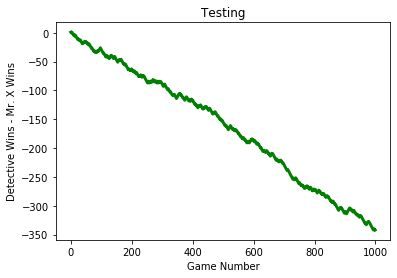

In [0]:
# TESTING CODE

batch_size = 256 #256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10 # how often we update target with policy n/w
memory_size = 100000 #check with paper
lr = 0.001
num_episodes = 1000 #1000
# state_dim = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

start_state = [118, 5, [34, 29, 117, 174, 112], [[10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4], [10, 8, 4]], 1]
start_feature = generate_feature_space(start_state)

em = Environment(start_state[0], start_state[1], start_state[2], start_state[3])
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

agent = Agent(strategy, em.num_actions_available(), device)
#print ('No. of available actions: ', em.num_actions_available())
memory = ReplayMemory(memory_size)

policy_net = model

mr_x_win = 0
detectives_win = 0
performance = []
game_number = []
for episode in range(num_episodes):
    #reset the environmet
    em = Environment(start_state[0], start_state[1], start_state[2], start_state[3])
    #print ('Reset',em.x_position)
    
    #getting initial state
    state = em.get_state(0)

    for timestep in range(25):
      action_tensor = agent.select_action_testing(state, policy_net, em.board[em.x_position])

      action = action_tensor.tolist()
      #print('Move to take for Mr. X', agent.mappings[action[0]])
      
      reward = em.take_action(action_tensor, timestep)
      #print ('Reward',reward)
      
      next_state = em.get_state(timestep)
      #print ('Next State in the form of feature vector',next_state)
      
      state = next_state
   
      if em.is_done(timestep) == 2 :
        mr_x_win += 1
        performance.append(detectives_win - mr_x_win)
        game_number.append(episode)
        break

      elif(em.is_done(timestep) == 1):
        detectives_win += 1
        performance.append(detectives_win - mr_x_win)
        game_number.append(episode)
        #plot(episode_durations, 100)
        break
    
    print("Episode number: ", episode)

print("Total number of episodes: ", num_episodes)
print("Mr. X wins: ", mr_x_win)
print("Detectives wins: ", detectives_win)

print (performance)
print (game_number)
plot_testing(performance, game_number)